# Integrantes

-Martín Kondratzky

-Agustín Fernández

# Librerias & Datos

In [ ]:
import torch


In [ ]:
#!pip install d2l
#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json
#!pip install pycountry_convert

import torch
from torch import nn
import pandas as pd
import numpy as np
from d2l import torch as d2l
import json
#from google.colab import files
import pycountry_convert as pc
from IPython import display
from torch.optim import lr_scheduler


#api_token = {"username":"k0ndr4","key":"9ec1191895c870bb0505c7918e027ba7"}
#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle competitions download -c tp-n2-aprendizaje-profundo-2021-by-datitos-v2
#!unzip fifa2021_test.csv.zip
#!unzip fifa2021_training.csv.zip

# Cargamos archivos 
train_data = pd.read_csv('fifa2021_training.csv')
test_data = pd.read_csv('fifa2021_test.csv')
print(train_data.shape)
print(test_data.shape)

(13921, 53)
(5909, 52)


# Preprocesamiento

In [ ]:
#Agregamos una columna de continentes. Esto lo hicimos creyendo que la diferencia física por regiones podía ser un factor importante a la hora de reconocer
#el posicionamiento de los jugadores en el campo.  

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        d = {'Korea Republic': 'Asia',
             'Wales': 'Europe',
             'Bosnia & Herzegovina': 'Europe'}
        pass#return d[country_name]

# Example
country_name = 'England'
print(country_to_continent(country_name))

#Concatenamos data sets y eliminamos columnas que no aportan información
all_features = pd.concat((train_data.iloc[:, :-1], test_data))
all_features['Continent'] = [country_to_continent(i) for i in all_features['Natinality'].values]

features_to_drop = ['ID',
                    'Name',
                    'Club',
                    'BirthDate',
                    'Club_KitNumber',
                    'Club_JoinedClub',
                    'Club_ContractLength',
                    'Natinality',
                    ]

all_features = all_features.drop(features_to_drop, axis=1)
all_features.head()

#Visualizamos tipos de datos de nuestro data frame
#all_features.dtypes

#Contabilizamos valores nulos
#all_features.isna().sum()

None


,Overal,Potential,Height,Weight,PreferredFoot,Age,PlayerWorkRate,WeakFoot,SkillMoves,Value,...,Curve,FKAcc,Penalties,Volleys,GKDiving,GKHandling,GKKicking,GKReflexes,Sex,Continent
0,64,73,188,79,R,22,Medium/Medium,3,2,1200000.0,...,39,33,43,41,13,10,13,12,Male,Europe
1,67,70,172,64,R,25,High/Medium,3,3,1400000.0,...,64,61,65,59,12,9,6,15,Male,Europe
2,68,68,173,70,L,28,Medium/Medium,2,2,1100000.0,...,58,34,49,46,15,6,15,16,Male,North America
3,63,70,190,76,L,22,Medium/High,3,2,900000.0,...,25,29,48,39,9,12,11,6,Male,South America
4,69,72,178,68,R,25,High/Medium,3,3,1800000.0,...,56,43,56,53,8,11,10,15,Male,South America


In [ ]:
#Estandarizamos valores numéricos
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features].isna().sum()

all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(all_features[numeric_features].mean())

# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)

#all_features.shape
all_features.head()

,Overal,Potential,Height,Weight,Age,WeakFoot,SkillMoves,Value,Wage,BallControl,...,Sex_Female,Sex_Male,Sex_nan,Continent_Africa,Continent_Asia,Continent_Europe,Continent_North America,Continent_Oceania,Continent_South America,Continent_nan
0,-0.336304,0.223299,0.981364,0.567831,-0.776243,0.053378,-0.498472,-0.259597,-0.404799,0.161472,...,0,1,0,0,0,1,0,0,0,0
1,0.066724,-0.239964,-1.286506,-1.483312,-0.144030,0.053378,0.764264,-0.239724,-0.331185,0.397767,...,0,1,0,0,0,1,0,0,0,0
2,0.201067,-0.548806,-1.144764,-0.662855,0.488182,-1.420827,-0.498472,-0.269533,-0.327095,0.161472,...,0,1,0,0,0,0,1,0,0,0
3,-0.470647,-0.239964,1.264848,0.157602,-0.776243,0.053378,-0.498472,-0.289405,-0.392530,-1.374449,...,0,1,0,0,0,0,0,0,1,0
4,0.335410,0.068878,-0.436055,-0.936340,-0.144030,0.053378,0.764264,-0.199979,-0.204405,0.574989,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
print(train_data['Position'].value_counts())
# Convierto la predicción a un número
train_data.Position = train_data.Position.astype('category')
print(train_data[['Position']])
dtype = pd.CategoricalDtype(['DEF', 'FWD', 'GK', 'MID'], ordered=False)
train_data['Position'] = train_data.Position.cat.codes
#print(train_data[['Position']])

MID    5071
DEF    4585
FWD    2715
GK     1550
Name: Position, dtype: int64
      Position
0          MID
1          MID
2          DEF
3          DEF
4          MID
5          MID
6           GK
7          FWD
8          MID
9          DEF
10         MID
11         DEF
12         MID
13         DEF
14         MID
15         MID
16          GK
17         DEF
18         DEF
19         DEF
20         MID
21         MID
22         DEF
23         MID
24         MID
25          GK
26         MID
27         DEF
28         FWD
29         DEF
...        ...
13891      FWD
13892       GK
13893      DEF
13894      MID
13895      DEF
13896      MID
13897       GK
13898      DEF
13899      FWD
13900       GK
13901      DEF
13902      DEF
13903      DEF
13904      DEF
13905      DEF
13906      DEF
13907      DEF
13908      DEF
13909      MID
13910      FWD
13911      FWD
13912      DEF
13913      FWD
13914      MID
13915      FWD
13916      MID
13917      MID
13918      MID
13919      DEF
13920   

In [ ]:
#Convertimos a Tensores
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.Position.values, dtype=torch.long)#.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

#Dividimos en Set de train y validación

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split (train_features, train_labels, train_size=0.95)
Y_train

tensor([2, 0, 3,  ..., 1, 0, 3])

# Funciones auxiliares

In [ ]:
#Definimos acumulador

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
        
def get_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['DEF', 'FWD', 'GK', 'MID']
    return [text_labels[int(i)] for i in labels]
  
#print(get_labels([0,1,2,3]))

#Definimos clase para plotear

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 7)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# TODO: Reescribir para que use la métrica adecuada
from sklearn.metrics import balanced_accuracy_score

#Función de accuracy
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def bal_accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    return balanced_accuracy_score(y, y_hat)
    
def evaluate_accuracy(net, data_iter, loss):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(4)  # No. of correct predictions, loss, no. of predictions
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(accuracy(net(X), y), l.sum(), y.numel(), bal_accuracy(net(X), y))
    #acc = metric[3] balanced
    acc = metric[0] / metric[2]
    loss = metric[1]# / metric[2]
    return acc, loss
  

#def evaluate_loss(net, data_iter, loss): #@save
#    """Evaluate the loss of a model on the given dataset."""
#    metric = d2l.Accumulator(2) # Sum of losses, no. of examples
#    for X, y in data_iter:
#      l = loss(net(X), y)
#      metric.add(l.sum(), l.size)
#    return metric[0] / metric[1]



# Scheduler

In [ ]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

scheduler = SquareRootScheduler(lr=0.1)

In [ ]:
#Función de entrenamiento

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size, scheduler=None):
    train_ls, test_ls = [], []
    animator = Animator(xlabel='epoch', ylabel = 'loss', xlim=[1, num_epochs], ylim=[0., 1],
                        legend=['train acc', 'test acc', 'train loss', 'test loss'])

    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay,
                                 )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        #print(f'*** iteración {epoch} ***')
        train_accuracy, train_loss = evaluate_accuracy(net, train_iter, loss)
        #print('Accuracy train', accuracy)
        train_ls.append(train_accuracy)
        if test_labels is not None:
            test_iter = d2l.load_array((test_features, test_labels), batch_size)
            test_accuracy, test_loss = evaluate_accuracy(net, test_iter, loss)
            #print('Accuracy test', test_accuracy)
            test_ls.append(test_accuracy)
            animator.add(epoch + 1, (train_accuracy, test_accuracy, train_loss, test_loss))
            
        if scheduler:
            #if scheduler.__module__ == lr_scheduler.__name__:
            #    # Using PyTorch In-Built scheduler
            #    scheduler.step()
            #else:
            #    # Using custom defined scheduler
            #    for param_group in trainer.param_groups:
            learning_rate = scheduler(epoch)
    return train_ls, test_ls

# Training

In [ ]:
# Inicialización de Xavier
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

#Definimos estructura de bloque para insertar en nuestra red

def block1(n_neuronas):
    return nn.Sequential(nn.Linear(n_neuronas, n_neuronas), 
                         nn.PReLU(),
                         nn.Dropout(dropout))

#Contruímos nuestra red

def get_net(n_blocks, n_neuronas, dropout):
    modules = []
    modules.extend([nn.Linear(in_features, 64),
                    nn.PReLU(),
                    nn.Dropout(0.1),
                    nn.Linear(64, n_neuronas),
                    nn.PReLU(),
                    nn.Dropout(dropout)])
    
    
    for i in range(n_blocks):
        # Nested here
        modules.append(block1(n_neuronas))
    modules.extend([nn.Linear(n_neuronas, 256),
                    nn.PReLU(),
                    #nn.Dropout(dropout),
                    #nn.Linear(256, 128),
                    #nn.PReLU(),
                    #nn.Dropout(dropout),
                    nn.Linear(256, out_features)])
    net = nn.Sequential(*modules)
    [net[i].apply(xavier) for i in range(len(net))]
    return net

def get_1hidden_net(n_neuronas, dropout):
    modules = []
    modules.extend([nn.Linear(in_features, n_neuronas),
                    nn.PReLU(),
                    nn.Dropout(dropout),
                    nn.Linear(n_neuronas, out_features)])
    net = nn.Sequential(*modules)
    [net[i].apply(xavier) for i in range(len(net))]
    return net

([0.7116606170598911,
  0.7859951603145795,
  0.8294767090139141,
  0.852994555353902,
  0.854053236539625,
  0.8709921355111918,
  0.8729582577132486,
  0.8799909255898367,
  0.8808983666061706,
  0.8820326678765881,
  0.8865698729582577,
  0.8831669691470054,
  0.8905777374470659,
  0.8874016938898972,
  0.8832425892317,
  0.8825620084694494,
  0.8877041742286751,
  0.890426497277677,
  0.8926950998185118,
  0.8949637023593466,
  0.8939050211736237,
  0.8945856019358742,
  0.890426497277677,
  0.895644283121597,
  0.8933756805807622,
  0.8897459165154264,
  0.8949637023593466,
  0.8908802177858439,
  0.896854204476709,
  0.8967785843920145,
  0.8967785843920145,
  0.8983666061705989,
  0.8943587416817906,
  0.8900483968542044,
  0.8923169993950393,
  0.8917876588021778,
  0.8975347852389595,
  0.890124016938899,
  0.8991228070175439,
  0.8990471869328494,
  0.8958711433756806,
  0.8925438596491229,
  0.8979885057471264,
  0.9004839685420448,
  0.8980641258318209,
  0.896400483968542,

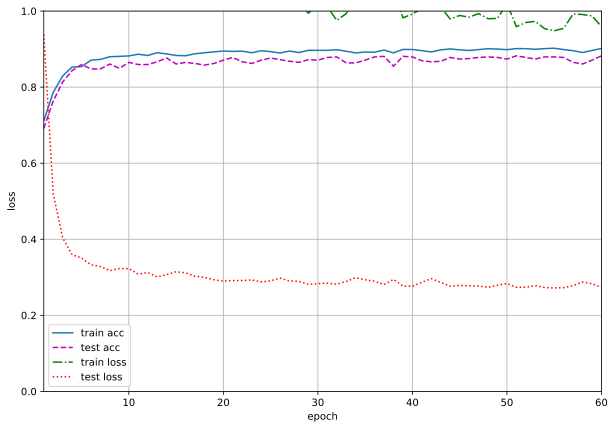

In [ ]:
#Entrada y salida de nuestra red
in_features = train_features.shape[1]
out_features = 4 #'DEF', 'FWD', 'GK', 'MID'

#Definimos función de pérdida
loss = nn.CrossEntropyLoss()
#nSamples = [4585, 2715, 10000, 5071]
#normedWeights = [1 - (x / sum(nSamples)) for x in nSamples]
#normedWeights = torch.tensor(normedWeights, dtype=torch.float32)
#print(normedWeights)
#loss = nn.CrossEntropyLoss(weight=normedWeights)

#Definimos hiperparátros
n_blocks = 4
n_neuronas = 1024
dropout = 0.5

#Instanciamos 

net = get_net(n_blocks, n_neuronas, dropout)

#Corremos nuestro modelo

train(net, 
      X_train, 
      Y_train, 
      X_test, 
      test_labels=Y_test,
      num_epochs=60, 
      learning_rate=0.0005,#0.002, 
      weight_decay=0.01, 
      batch_size=4096,
      #scheduler=scheduler
     )

# Predicción

In [ ]:
#Predicciones sobre el conjunto de entrenamiento

preds_train = get_labels(net(X_train).argmax(axis=1))
set(preds_train)

In [ ]:
#Predicciones sobre conjunto de validación
preds_val = get_labels(net(X_test).argmax(axis=1))
set(preds_val)

In [ ]:
#Predicciones sobre conjunto de Test

preds = get_labels(net(test_features).argmax(axis=1))

respuesta = pd.DataFrame({'Id':test_data['ID'], 'Category':preds})
filename = 'submission1.csv'
respuesta.to_csv(filename, index=False)

# Análisis de errores

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
Y_test_labels = get_labels(Y_test)

In [ ]:
#Matriz de confusión general
matriz_general = multilabel_confusion_matrix(Y_test_labels, preds_val)
matriz_general


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(Y_test_labels, preds_val)
print(report)
        
# Confusion matrix
cm = confusion_matrix(Y_test_labels, preds_val)
df_cm = pd.DataFrame(cm, 
                      index = range(4),
                      columns = range(4))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [ ]:
#Matriz de confusión hombres
X_test_total = torch.cat((X_test, Y_test.unsqueeze(1)),1)
X_test_masculino = X_test_total[X_test_total[:,-10] == 1]
Y_test_masculino = X_test_masculino[:,-1]
X_test_masculino = X_test_masculino[:,:-1 ]
X_test_masculino



In [ ]:
preds_test_masculino = get_labels(net(X_test_masculino).argmax(axis=1))
set(preds_test_masculino)
len(preds_test_masculino)


In [ ]:
Y_test_masculino = get_labels(Y_test_masculino)

In [ ]:
matriz_hombres = multilabel_confusion_matrix(Y_test_masculino, preds_test_masculino)
matriz_hombres

In [ ]:
#matriz femenina
X_test_total = torch.cat((X_test, Y_test.unsqueeze(1)),1)
X_test_femenino = X_test_total[X_test_total[:,-11] == 1]
Y_test_femenino = X_test_femenino[:,-1]
X_test_femenino = X_test_femenino[:,:-1 ]
X_test_femenino.shape


In [ ]:
preds_test_femenino = get_labels(net(X_test_femenino).argmax(axis=1))
set(preds_test_femenino)
len(preds_test_femenino)

In [ ]:
Y_test_femenino = get_labels(Y_test_femenino)

In [ ]:
matriz_mujeres = multilabel_confusion_matrix(Y_test_femenino, preds_test_femenino)
matriz_mujeres

In [ ]:
respuesta['Sex'] = test_data['Sex']
respuesta.groupby(['Sex', 'Category']).size()

In [ ]:
respuesta.loc[respuesta.Sex=='Female']

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

#Comenzamos optimización de hiperparámetros definiendo nuestra Grilla

param_grid = {#'n_blocks' : [0,1,2],
              'n_neuronas' : [128, 256, 512, 1024],
              'num_epochs' : [10, 14, 20, 30],#[8,10,12,14],
              'learning_rate' : [1e-2, 5e-4],
              'weight_decay' : [1e-2, 1e-4, 1e-6],
              'dropout' : [0.3, 0.5, 0.7],
              }

grid = list(ParameterGrid(param_grid))
len(grid)

In [ ]:
#Definimos función para optimizar hiperparámetros
results = {}
for i, params in enumerate(grid):
    print(i)
    print(params)
    net = get_1hidden_net(params['n_neuronas'], params['dropout'])
    train_metrics, test_metrics = train(net, 
                                    X_train, 
                                    Y_train, 
                                    X_test, 
                                    test_labels=Y_test,
                                    num_epochs=params['num_epochs'], 
                                    learning_rate=params['learning_rate'],
                                    weight_decay=params['weight_decay'], 
                                    batch_size=4096,
                                    scheduler=scheduler)

    test_metrics_final = round(test_metrics[-1], 4)
    results[test_metrics_final] = params
    print(test_metrics_final)
    if test_metrics[-1]>0.91:
        print('************************************')
        print(test_metrics_final)
        print(params)
        print('************************************')
        preds = get_labels(net(test_features).argmax(axis=1))
        respuesta = pd.DataFrame({'Id':test_data['ID'], 'Category':preds})
        filename = 'submission{}.csv'.format(test_metrics_final)
        respuesta.to_csv(filename, index=False)

In [ ]:
dictionary_items = results.items()
sorted_items = sorted(dictionary_items)
for i in sorted_items[-10:]:
    print(i)




# Entreno con los mejores hiperparámetros

In [ ]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.Position.values, dtype=torch.long)#.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split (train_features, train_labels, train_size=0.95)
Y_train

In [ ]:
#Entrenamos modelo buscando optimizar hiperparámetros

params = sorted_items[-1][1]#{'dropout': 0.3, 'learning_rate': 0.001, 'n_blocks': 1, 'n_neuronas': 1024, 'num_epochs': 10, 'weight_decay': 1e-06}
net = get_net(params['n_blocks'], params['n_neuronas'], params['dropout'])
train_metrics, test_metrics = train(net, 
                                X_train, 
                                Y_train, 
                                X_test, 
                                test_labels=Y_test,
                                num_epochs=params['num_epochs'], 
                                learning_rate=params['learning_rate'],
                                weight_decay=params['weight_decay'], 
                                batch_size=4096,
                                scheduler=scheduler)

test_metrics_final = round(test_metrics[-1], 4)
results[test_metrics_final] = params
print(test_metrics_final)
#if test_metrics[-1]>0.91:
print('************************************')
print(test_metrics_final)
#print(params)
print('************************************')
preds = get_labels(net(test_features).argmax(axis=1))
respuesta = pd.DataFrame({'Id':test_data['ID'], 'Category':preds})
filename = 'submission{}.csv'.format(test_metrics_final)
respuesta.to_csv(filename, index=False)

# Submission Automatica

In [ ]:
#files.download(filename)
!kaggle competitions submit -c tp-n2-aprendizaje-profundo-2021-by-datitos-v2 -f submission1.csv -m "Message"